# Imports

In [146]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
# pd.set_option('display.max_rows', 500)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns; sns.set()
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
%matplotlib inline

import wandb

In [3]:
wandb.login()

wandb: Currently logged in as: covid-forecasters (use `wandb login --relogin` to force relogin)


True

In [4]:
wandb_run = wandb.init(project="CovidForecaster")

In [5]:
artifact = wandb.Artifact('my-dataset', type='dataset')
artifact.add_file('data/state_mobility_cases_agg=max_2020.csv')
wandb_run.log_artifact(artifact)

# Utils

In [3]:
def compare(dataframe, fields):
    fig, ax = plt.subplots(figsize=(10,10))
    for f in fields:
        ax.plot(dataframe["Date"], dataframe[f], label=f)
    ax.legend(loc="best")

In [4]:
def mobility_check(df, where, what, everything=False, save=False):
    fig, ax = plt.subplots(figsize=(10,10))
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    ax.plot(df[df["State"]==where]["Date"], sc.fit_transform(df[df["State"]==where]["new cases"].to_numpy().reshape(-1, 1)), label=f"Cases @ {where}")
    sc = StandardScaler()
    ll = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline',]
    if everything:
        for l in ll:
            ax.plot(df[df["State"]==where]["Date"], sc.fit_transform(df[df["State"]==where][l].to_numpy().reshape(-1, 1)), label=l)
    else:
        ax.plot(df[df["State"]==where]["Date"], sc.fit_transform(df[df["State"]==where][what].to_numpy().reshape(-1, 1)), label=what)
    ax.legend(loc="best")
    if save:
        plt.savefig(f"{where},{what if not everything else ''}.png")

# Data Collection and Analysis

In [59]:
df = pd.read_csv("data/India_OWID_with_mobility_data.csv")
df["date"] = pd.to_datetime(df["date"])
# df=df.dropna()
# print(df.info())
df.drop(["tests_units", "date", "location"], axis=1, inplace=True)
# type(df["new_cases"][0])


scaler = StandardScaler()
# df_no_date_no_place = df.drop(["date"], axis=1)
df[df.columns] = scaler.fit_transform(df[df.columns])
# df.dropna()

corr = df.corr()["new_cases"]
gg = corr.sort_values(key=lambda x: abs(x), ascending=False)
gg
# fig, ax = plt.subplots(figsize=(30,30)
# sns.heatmap(np.array(gg).reshape(66,1),cmap=cmap)
# mask = np.triu(np.ones_like(corr, dtype=bool))
# f, ax = plt.subplots(figsize=(20, 20))

# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})
# plt.savefig("corr.png")

# fig, ax = plt.subplots(figsize=(30,30))
# for l in df.columns:
#     print(l)
#     if l in ["date","tests_units"]:
#         continue
#     ax.plot(df["date"], df[l], label=l)
# ax.legend(loc="best")

# df["Date"]=pd.to_datetime(df["date"])
# df.drop("date", axis=1, inplace=True)
# # print(df.columns)
# ll = ['new_cases','new_deaths','total_deaths'
#        'reproduction_rate', 'icu_patients','hosp_patients', 'weekly_icu_admissions',
#         'weekly_hosp_admissions',
#         'new_tests', 
#        'positive_rate', 'extreme_poverty', 'handwashing_facilities', 'hospital_beds_per_thousand',
#        'life_expectancy', 'human_development_index',
#        '7_day_lagged_retail_and_recreation_percent_change_from_baseline',
#        '7_day_lagged_grocery_and_pharmacy_percent_change_from_baseline',
#        '7_day_lagged_parks_percent_change_from_baseline',
#        '7_day_lagged_transit_stations_percent_change_from_baseline',
#        '7_day_lagged_workplaces_percent_change_from_baseline',
#        '7_day_lagged_residential_percent_change_from_baseline', 'Date']
# # print([c for c in df.columns if c not in ll])
# df.drop([c for c in df.columns if c not in ll], inplace=True, axis=1)

# df = df[30:]
# df = df.dropna(axis=1)


/home/think__tech/.local/lib/python3.6/site-packages/sklearn/utils/extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/think__tech/.local/lib/python3.6/site-packages/sklearn/utils/extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


new_cases                                                          1.000000
new_cases_per_million                                              1.000000
new_cases_smoothed_per_million                                     0.984190
new_cases_smoothed                                                 0.984190
people_vaccinated_per_hundred                                      0.961461
people_vaccinated                                                  0.961395
total_vaccinations                                                 0.954796
total_vaccinations_per_hundred                                     0.954789
new_vaccinations_smoothed                                          0.927926
new_vaccinations_smoothed_per_million                              0.927926
people_fully_vaccinated                                            0.900499
people_fully_vaccinated_per_hundred                                0.900324
new_deaths_smoothed_per_million                                    0.850584
new_deaths_s

In [60]:
df.columns

Index(['total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths',
       'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations',
       'new_vaccinations_smoothed', 'total_vaccinations_per_hundred',
       'people_vaccinated_per_hundred', 'people_fully_vaccin

In [61]:
df = pd.read_csv("India_data.csv")
df["Date"]=pd.to_datetime(df["date"])
print(df.shape)
df= df.dropna()
print(df.shape)
df = df[["7_day_lagged_grocery_and_pharmacy_percent_change_from_baseline", "Date"]]
df.shape

(385, 14)
(385, 14)


(385, 2)

In [62]:
scaler = MinMaxScaler()
df_no_date_no_place = df.drop(["Date"], axis=1)
df[df_no_date_no_place.columns] = scaler.fit_transform(df[df_no_date_no_place.columns])
df

,7_day_lagged_grocery_and_pharmacy_percent_change_from_baseline,Date
0,0.738964,2020-03-20
1,0.738964,2020-03-21
2,0.746641,2020-03-22
3,0.740883,2020-03-23
4,0.591171,2020-03-24
5,0.539347,2020-03-25
6,0.445298,2020-03-26
7,0.320537,2020-03-27
8,0.195777,2020-03-28
9,0.080614,2020-03-29


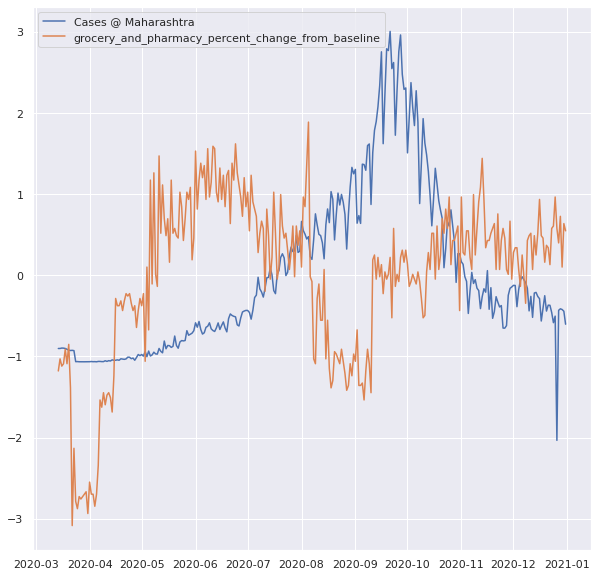

In [36]:
mobility_check(df,"Maharashtra", "grocery_and_pharmacy_percent_change_from_baseline")

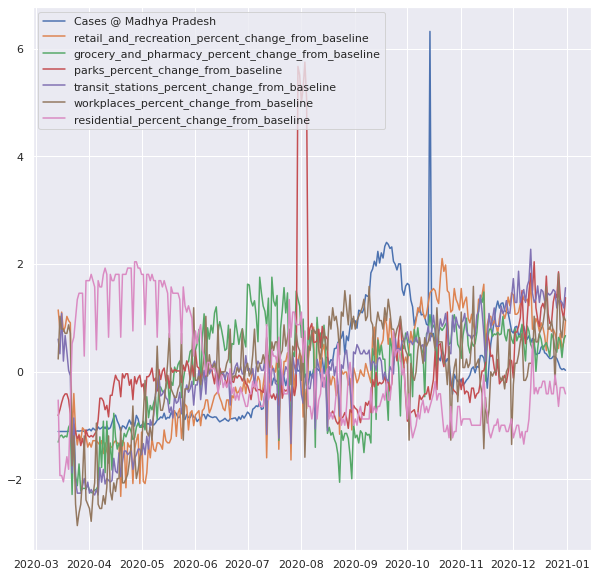

In [41]:
mobility_check(df, "Madhya Pradesh", "grocery_and_pharmacy_percent_change_from_baseline", True, True)

# Algorithm Developement

In [63]:
def sliding_window(data, seq_len):

    xs = []
    ys = []
    for i in range(len(data)-seq_len-1):
        x = data[i:(i+seq_len)].drop(["Date"], axis=1).to_numpy().flatten()
        y = data[(i+seq_len):i+seq_len+1]["7_day_lagged_grocery_and_pharmacy_percent_change_from_baseline"].to_numpy()[0]
        xs.append(x)
        ys.append(y)

  
    return np.array(xs, dtype=np.float64), np.array(ys, dtype=np.float64)

In [96]:
class CoronaVirusPredictor(nn.Module):

    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()

        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
          input_size=n_features,
          hidden_size=n_hidden,
          num_layers=n_layers,
          dropout=0.5
        )

        self.linear = nn.Linear(in_features=n_hidden, out_features=1)

    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )

    def forward(self, sequences):
#         print("Forward Starts\n-------")
#         print(f"{sequences.view(len(sequences), self.seq_len, -1).shape}")
        lstm_out, self.hidden = self.lstm(
          sequences.view(len(sequences), self.seq_len, -1),
          self.hidden
        )
#         print(lstm_out.shape)
#         print(f"lstm_out.view(self.seq_len, len(sequences), self.n_hidden):{lstm_out.view(self.seq_len, len(sequences), self.n_hidden).shape}")
        last_time_step = \
          lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
#         print("##")
#         print(lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1:].shape)
#         print(lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1].shape)
#         print("##")
#         print(f"##{lstm_out.shape}##")
#         print(lstm_out.view(self.seq_len, len(sequences), self.n_hidden).shape)
#         print(f"last{last_time_step.shape}")
        y_pred = self.linear(last_time_step)
#         print(y_pred.shape)
#         print("Forward Ends\n-------")
        return y_pred

In [80]:
def train_model(
        model, 
        train_data, 
        train_labels, 
        test_data=None, 
        test_labels=None
    ):
    loss_fn = torch.nn.MSELoss(reduction='sum')

    optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 120

    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)

    for t in range(num_epochs):
        model.reset_hidden_state()

        y_pred = model(X_train)

        loss = loss_fn(y_pred.float().flatten(), y_train)

        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
                test_hist[t] = test_loss.item()

            if t % 10 == 0:  
                print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')

        train_hist[t] = loss.item()

        optimiser.zero_grad()

        loss.backward()

        optimiser.step()

    return model.eval(), train_hist, test_hist

In [73]:
tscv = TimeSeriesSplit()

In [ ]:
for train_index, test_index in tscv.split(X):
#         v += 1
        X_train, y_train = torch.from_numpy(data[train_index]), torch.from_numpy(labels[train_index])
        X_test, y_test = torch.from_numpy(data[test_index]), torch.from_numpy(labels[test_index])

In [149]:
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=32, 
  seq_len=1, 
  n_layers=2
)

# wandb.watch(model)
model.train()

from tqdm.notebook import trange

def train_model_with_crossval(
        model, 
        data, 
        labels,
        tscv,
    ):
    model = model.float()
    
    r2_scores, test_error_mse, test_error_mae = [], [], []
    train, test = {}, {}
    train['feats'], train['pred'], train['true'] = {}, {}, {}
    test['feats'], test['pred'], test['true'] = {}, {}, {}

    v = 0
    for train_index, test_index in tscv.split(data):
        v += 1
        X_train, y_train = torch.from_numpy(data[train_index]), torch.from_numpy(labels[train_index])
        X_test, y_test = torch.from_numpy(data[test_index]), torch.from_numpy(labels[test_index])
        print(X_train.shape, X_test.shape)
        train['feats'][v] = X_train.numpy()
        test['feats'][v] = X_test.numpy()
    
        loss_fn = torch.nn.L1Loss(reduction='mean')
        loss_fn2 = torch.nn.MSELoss(reduction='mean')

        optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
        num_epochs = 60

        train_hist = np.zeros(num_epochs)
        test_hist = np.zeros(num_epochs)

        for t in (trange(num_epochs)):
            model.train()
            model.reset_hidden_state()
#             print(f"sadasda", X_train.shape)
            y_pred = model(X_train.float()).squeeze()

            loss = loss_fn2(y_pred.float().flatten(), y_train.float())
#             wandb.log({f"train_loss{v}": loss.item()})
            train_hist[t] = loss.item()

            optimiser.zero_grad()

            loss.backward()

            optimiser.step()
        
        with torch.no_grad():
            model.eval()
            y_train_pred = model(X_train.float()).squeeze()
            

            train['pred'][v] = y_train_pred.numpy().tolist()
            train['true'][v] = y_train.numpy().tolist()
            
            y_test_pred = []
            test['pred'][v] = []
            test['true'][v] = y_test.numpy().tolist()
            for i in range(X_test.shape[0]):
#                 print(f"X_train: {X_train.shape}")
                
                model_output = model(X_train.float()).squeeze()
#                 print(f"model out shape: {model_output.shape}")
                last_day_from_model = model_output[-1].item()
                y_test_pred.append(last_day_from_model)
#                 len(y_test_pred)
#                 print(f"y_test_pred: {type(y_test_pred[-1].item())}" )
#                 print(f"listshape: {len(X_train.squeeze().tolist())}")
#                 print(f"{len(X_train.squeeze().tolist().append(y_test_pred[-1].item()))}")
#                 print(f"X_train_numpyshape:{np.array(X_train.squeeze().tolist().append(y_test_pred[-1])).shape}")
                X_train_list_form = X_train.squeeze().numpy().tolist()
#                 print(type(X_train_list_form[0]))
                X_train_list_form.append(last_day_from_model)
#                 print(len(X_train_list_form))
#                 print(type(last_day_from_model))
                X_train = torch.tensor(X_train_list_form, dtype=torch.float64).reshape(-1, 1)
#                 X_train = torch.tensor(np.array(X_train.squeeze().tolist().append(y_test_pred[-1]), dtype=np.float64).reshape(-1, 1))

                test['pred'][v].append(last_day_from_model)
                
    #             wandb.log({f"test_mse_loss{v}": loss_fn2(y_test_pred.float(), y_test).item()})
    #             wandb.log({f"test_mae_loss{v}": loss_fn(y_test_pred.float(), y_test).item()})
            test_error_mae.append(loss_fn(torch.tensor(y_test_pred).float(), y_test).item())
            test_error_mse.append(loss_fn2(torch.tensor(y_test_pred).float(), y_test).item())
            r2_scores.append(r2_score(torch.tensor(y_test).numpy(), torch.tensor(y_test_pred).float().numpy()))
#     print(v)
                


    return r2_scores, test_error_mae, test_error_mse, train, test

X, y = sliding_window(df, 1)
print("''''''''''''''''", X.shape)
# X = torch.from_numpy(X).float()
# y = torch.from_numpy(y).float()
r2_scores, test_error_mae, test_error_mse, train, test = train_model_with_crossval(
    model, 
    X, 
    y,
    tscv,
)


'''''''''''''''' (383, 1)
torch.Size([68, 1]) torch.Size([63, 1])



torch.Size([131, 1]) torch.Size([63, 1])


/home/think__tech/.local/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



torch.Size([194, 1]) torch.Size([63, 1])


/home/think__tech/.local/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



torch.Size([257, 1]) torch.Size([63, 1])


/home/think__tech/.local/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



torch.Size([320, 1]) torch.Size([63, 1])


/home/think__tech/.local/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/home/think__tech/.local/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [20]:
torch.save(model, "model.h5")

In [21]:
artifact = wandb.Artifact('my-model', type='model')
artifact.add_file('model.h5')
wandb_run.log_artifact(artifact)

In [23]:
wandb.log({"r2_scores": r2_scores.mean(), "test_error_mae":test_error_mae, "test_error_mse":test_error_mse})

In [147]:
r2_scores, test_error_mae, test_error_mse

([-42.933087621982864,
  -68.44036295925022,
  -8.225837588727867,
  0.018470803243129552,
  -30.172570139605092],
 [0.41010393630367614,
  0.26795500575228587,
  0.16156287160865604,
  0.02508020117532518,
  0.16245451300162253],
 [0.17254950606362376,
  0.08886193421579554,
  0.029479727230489475,
  0.001080804302965155,
  0.028040024245756235])

In [41]:
len(test["pred"][5])

63

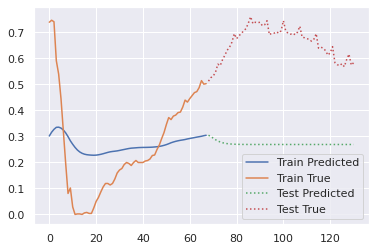

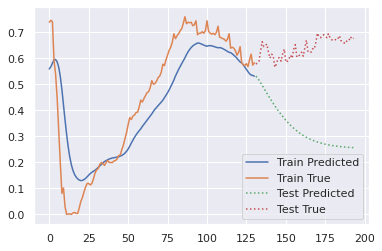

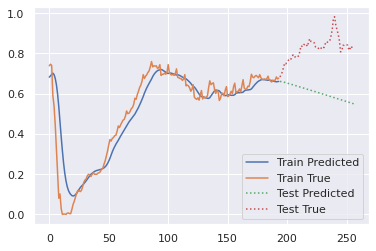

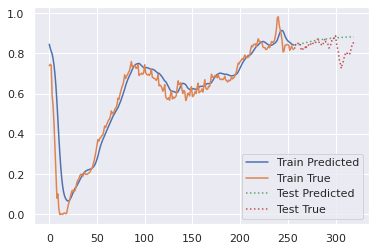

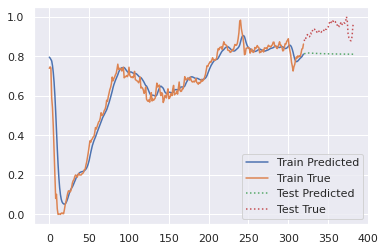

In [150]:
for i in range(1,6):
#     fig, ax = plt.subplots(figsize=(6,6))
    plt.plot(list(range(0,len(train['pred'][i]))),train['pred'][i],label='Train Predicted')
    plt.plot(list(range(0,len(train['true'][i]))),train['true'][i],label='Train True')
    plt.plot(list(range(len(train['pred'][i]),len(train['pred'][i])+len(test['pred'][i]))),test['pred'][i],label='Test Predicted', linestyle='dotted')
    plt.plot(list(range(len(train['true'][i]),len(train['true'][i])+len(test['true'][i]))),test['true'][i],label='Test True', linestyle='dotted')
    plt.legend()

    plt.show()

IndexError: index 7 is out of bounds for axis 1 with size 7

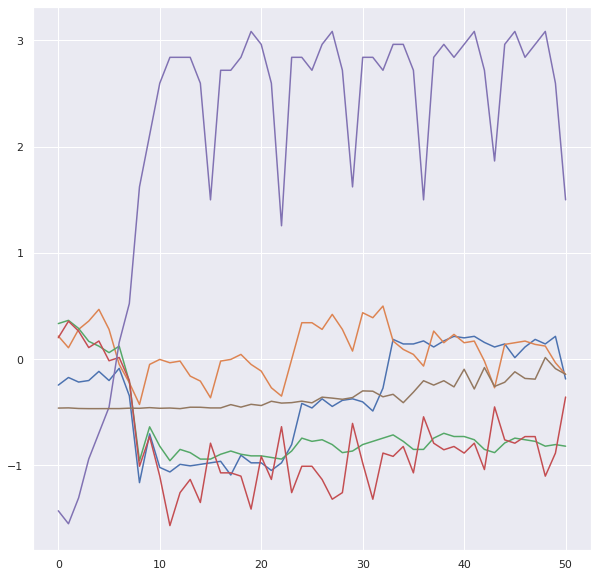

In [157]:
fig, ax = plt.subplots(figsize=(10,10))
v = 1
for i in range(1,10):  
    plt.plot(list(range(0,len(train['feats'][v]))),train['feats'][v][:,i],label=f'Feature {i}')
plt.plot(list(range(0,len(train['true'][v]))),train['true'][v],label='True',linewidth=5)
plt.plot(list(range(0,len(train['pred'][v]))),train['pred'][v],label='Predicted',linewidth=5)

plt.legend()
plt.show()


fig, ax = plt.subplots(figsize=(10,10))
v = 1
for i in range(10,20):  
    plt.plot(list(range(0,len(train['feats'][v]))),train['feats'][v][:,i],label=f'Feature {i}')
plt.plot(list(range(0,len(train['true'][v]))),train['true'][v],label='True',linewidth=5)
plt.plot(list(range(0,len(train['pred'][v]))),train['pred'][v],label='Predicted',linewidth=5)

plt.legend()
plt.show()


fig, ax = plt.subplots(figsize=(10,10))
v = 1
for i in range(20,31):  
    plt.plot(list(range(0,len(train['feats'][v]))),train['feats'][v][:,i],label=f'Feature {i}')
plt.plot(list(range(0,len(train['true'][v]))),train['true'][v],label='True',linewidth=5)
plt.plot(list(range(0,len(train['pred'][v]))),train['pred'][v],label='Predicted',linewidth=5)

plt.legend()
plt.show()

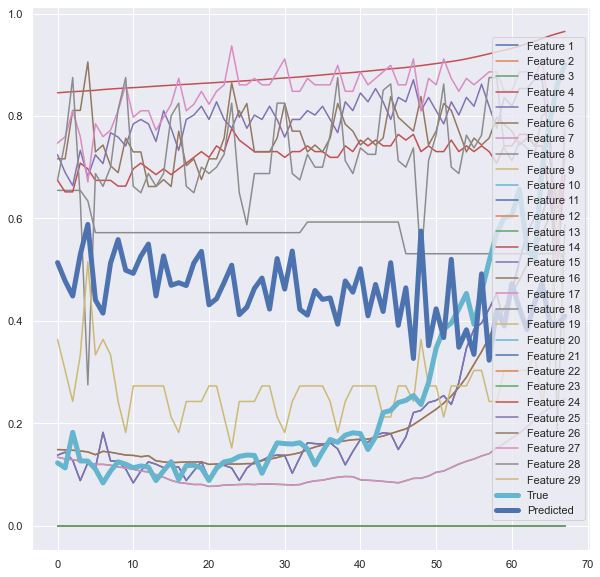

In [172]:
fig, ax = plt.subplots(figsize=(10,10))
v = 5
for i in range(1,30):  
    plt.plot(list(range(0,len(train[v]))),train[v][:,i],label=f'Feature {i}')
plt.plot(list(range(0,len(test[v]))),test[v],label='True',linewidth=5)
plt.plot(list(range(0,len(pred[v]))),pred[v],label='Predicted',linewidth=5)

plt.legend()
plt.show()

In [30]:
wandb_run.finish()

_runtime,210
_timestamp,1618993807
_step,5


_runtime,▁█████
_timestamp,▁█████
_step,▁▂▄▅▇█
